# Pipeline Fixer Agent

This agent is responsible for fixing issues in the pipeline whenever it's possible.
The agent will first do a troubleshoot to identify the root cause of the issue and if it's related with the codebase or external factors.

If the issue is related with the codebase, the agent will try to fix it by invoking the `apply_unittest_fix` tool or `apply_lint_fix` tool, depending on the type of issue. If the issue is related with external factors or not able to fix the pipeline, the agent will fallback to manual fix.


In [1]:
from langgraph.store.memory import InMemoryStore
from rich import print  # noqa: A004

from automation.agents.pipeline_fixer import PipelineFixerAgent
from automation.conf import settings
from automation.utils import file_changes_namespace

source_repo_id = "dipcode/django-webhooks"
source_ref = "feat/webhook-payload-truncation-1"

config = {
    "run_name": "PipelineFixer",
    "recursion_limit": settings.RECURSION_LIMIT,
    "configurable": {"source_repo_id": source_repo_id, "source_ref": source_ref, "thread_id": "1"},
}
store = InMemoryStore()

pipeline_fixer = PipelineFixerAgent(store=store)

## Graph

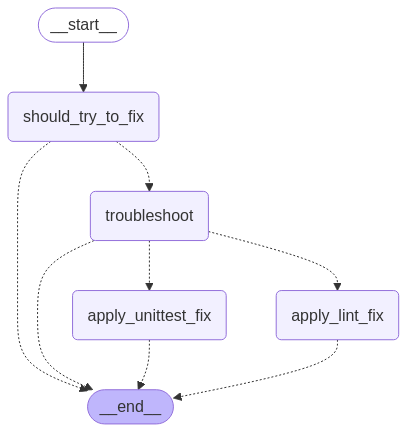

In [2]:
from IPython.display import Image, display  # noqa: A004

display(Image(pipeline_fixer.draw_mermaid()))

## Examples

Here are some examples of the agent in action.

### Pipeline fail: unittest errors

This example shows a pipeline failing due to a unittest. The agent will do a troubleshooting to identify the root cause of the issue and define a remediation plan. 
The plan will be bypassed to the `PlanAndExecuteAgent` to execute the remediation plan.

In [3]:
# Diff and job logs to be used in the examples
diff = """--- /dev/null
+++ b/webhooks/tests/test_truncation.py
@@ -0,0 +1,163 @@
+from unittest.mock import MagicMock, patch
+
+from django.test import TestCase, override_settings
+
+from webhooks.models import WebhookSubscription
+from webhooks.tasks import send_webhook_request
+from webhooks.utils import truncate_json_data
+
+
+class TruncateJsonDataTestCase(TestCase):
+    \"""Tests for the truncate_json_data utility function\"""
+
+    def test_truncate_string_exceeding_max_size(self):
+        \"""Test that strings exceeding max_size are truncated\"""
+        test_string = "a" * 2000
+        truncated = truncate_json_data(test_string, max_size=100, truncated_length=50)
+        self.assertEqual(len(truncated), 50 + len("... [truncated]"))
+        self.assertTrue(truncated.endswith("... [truncated]"))
+        self.assertEqual(truncated, "a" * 50 + "... [truncated]")
+
+    def test_truncate_nested_dict(self):
+        \"""Test that nested dictionaries are properly truncated\"""
+        test_data = {{"id": 123, "name": "test", "description": "a" * 2000, "metadata": {{"nested_key": "b" * 2000}}}}
+        truncated = truncate_json_data(test_data, max_size=100, truncated_length=50)
+
+        # Top level values should be truncated
+        self.assertEqual(truncated["id"], 123)
+        self.assertEqual(truncated["name"], "test")
+        self.assertEqual(truncated["description"], "a" * 50 + "... [truncated]")
+
+        # Nested values should also be truncated
+        self.assertEqual(truncated["metadata"]["nested_key"], "b" * 50 + "... [truncated]")
+
+    def test_truncate_list(self):
+        \"""Test that lists are properly truncated\"""
+        test_data = ["a" * 2000, "b" * 50, {{"key": "c" * 2000}}]
+        truncated = truncate_json_data(test_data, max_size=100, truncated_length=50)
+
+        self.assertEqual(truncated[0], "a" * 50 + "... [truncated]")
+        self.assertEqual(truncated[1], "b" * 50)  # Should not be truncated
+        self.assertEqual(truncated[2]["key"], "c" * 50 + "... [truncated]")
+
+    def test_blacklisted_keys(self):
+        \"""Test that blacklisted keys are always truncated\"""
+        test_data = {{
+            "id": 123,
+            "password": "secret_password",  # Should be truncated regardless of size
+            "token": "short_token",  # Should be truncated regardless of size
+            "data": {{
+                "nested_password": "another_secret"  # Should not be truncated (not in root)
+            }},
+        }}
+        truncated = truncate_json_data(
+            test_data,
+            max_size=1000,  # Large enough that non-blacklisted keys won't be truncated
+            truncated_length=10,
+            keys_blacklist=["password", "token"],
+        )
+
+        self.assertEqual(truncated["id"], 123)
+        self.assertEqual(truncated["password"], "secret_pas... [truncated]")
+        self.assertEqual(truncated["token"], "short_tok... [truncated]")
+        self.assertEqual(truncated["data"]["nested_password"], "another_secret")  # Not truncated
+
+    def test_non_string_values(self):
+        \"""Test that non-string values are not truncated\"""
+        test_data = {{"id": 123, "enabled": True, "ratio": 0.75, "null_value": None}}
+        truncated = truncate_json_data(test_data, max_size=10, truncated_length=5)
+
+        self.assertEqual(truncated["id"], 123)
+        self.assertEqual(truncated["enabled"], True)
+        self.assertEqual(truncated["ratio"], 0.75)
+        self.assertIsNone(truncated["null_value"])
+
+    @override_settings(WEBHOOKS_TRUNCATE_PAYLOADS=False)
+    def test_truncation_disabled(self):
+        \"""Test that truncation is skipped when disabled in settings\"""
+        test_data = {{"key": "a" * 2000}}
+        truncated = truncate_json_data(test_data, max_size=100, truncated_length=50)
+
+        # Should return the original data unchanged
+        self.assertEqual(truncated, test_data)
+
+
+class WebhookTruncationIntegrationTestCase(TestCase):
+    \"""Integration tests for webhook data truncation\"""
+
+    def setUp(self):
+        # Create a mock subscription
+        self.subscription = MagicMock(spec=WebhookSubscription)
+        self.subscription.url = "https://example.com/webhook"
+        self.subscription.uuid = "test-uuid"
+
+        # Mock the database query
+        self.patcher = patch("webhooks.tasks.WebhookSubscription.objects.select_related")
+        self.mock_select_related = self.patcher.start()
+        self.mock_manager = MagicMock()
+        self.mock_select_related.return_value = self.mock_manager
+        self.mock_manager.get.return_value = self.subscription
+
+        # Mock the actual HTTP request
+        self.request_patcher = patch("webhooks.tasks.requests.post")
+        self.mock_post = self.request_patcher.start()
+
+        # Setup mock response
+        self.mock_response = MagicMock()
+        self.mock_response.status_code = 200
+        self.mock_response.elapsed = 0.1
+        self.mock_response.headers = {{"Content-Type": "application/json"}}
+        self.mock_post.return_value = self.mock_response
+
+        # Mock the WebhookEvent model
+        self.event_patcher = patch("webhooks.tasks.WebhookEvent")
+        self.mock_event_class = self.event_patcher.start()
+        self.mock_event = MagicMock()
+        self.mock_event_class.return_value = self.mock_event
+        self.mock_event.uuid = "event-uuid"
+
+    def tearDown(self):
+        self.patcher.stop()
+        self.request_patcher.stop()
+        self.event_patcher.stop()
+
+    @patch("webhooks.tasks.truncate_json_data")
+    def test_truncation_applied_to_request_data(self, mock_truncate):
+        \"""Test that truncation is applied to request data\"""
+        # Setup mock truncation return value
+        mock_truncate.return_value = {{"truncated": True}}
+
+        # Set mock response JSON
+        self.mock_response.json.return_value = {{"status": "success"}}
+
+        # Call the task
+        test_payload = {{"test_key": "a" * 2000}}
+        send_webhook_request("test-uuid", "test-webhook", 12345, test_payload)
+
+        # Verify truncation was called for request data
+        mock_truncate.assert_any_call(test_payload)
+
+        # Verify the truncated data was set on the event
+        truncation_call_args = mock_truncate.call_args_list
+        self.assertEqual(self.mock_event.request, {{"truncated": True}})
+
+    @patch("webhooks.tasks.truncate_json_data")
+    def test_truncation_applied_to_response_data(self, mock_truncate):
+        \"""Test that truncation is applied to response data\"""
+        # Setup mock truncation to return different values for different calls
+        mock_truncate.side_effect = [
+            {{"request_truncated": True}},  # First call (for request data)
+            {{"response_truncated": True}},  # Second call (for response data)
+        ]
+
+        # Set mock response JSON
+        self.mock_response.json.return_value = {{"status": "success", "data": "a" * 2000}}
+
+        # Call the task
+        send_webhook_request("test-uuid", "test-webhook", 12345, {{"test": "data"}})
+
+        # Verify truncation was called for response data
+        mock_truncate.assert_any_call({{"status": "success", "data": "a" * 2000}})
+
+        # Verify the truncated data was set on the event
+        self.assertEqual(self.mock_event.response, {{"response_truncated": True}})

--- a/webhooks/conf.py
+++ b/webhooks/conf.py
@@ -18,6 +18,12 @@ class WebhooksAppConf(AppConf):
     TOKEN_ALGORITHM = "sha256"  # noqa: S105
     USER_AGENT = f"TrueClinic Webhook/{{__version__}}"

+    # Payload truncation settings
+    TRUNCATE_PAYLOADS = True
+    PAYLOAD_MAX_SIZE = 10 * 1024  # 10KB default maximum size for payload values
+    PAYLOAD_TRUNCATED_LENGTH = 1000  # Default length to truncate to
+    PAYLOAD_KEYS_BLACKLIST = []  # Keys to always truncate regardless of size
+
     class Meta:
         proxy = True
         prefix = "WEBHOOKS"

--- a/webhooks/tasks.py
+++ b/webhooks/tasks.py
@@ -17,7 +17,7 @@ from webhooks.constants import (

 from .conf import settings
 from .models import WebhookEvent, WebhookSubscription
-from .utils import generate_signature_token
+from .utils import generate_signature_token, truncate_json_data

 logger = logging.getLogger("webhooks")

@@ -68,7 +68,36 @@ def send_webhook_request(subscription_uuid: str, webhook: str, timestamp: int, p
             event.elapsed_time = response.elapsed
             event.response_headers = dict(response.headers)
             with suppress(JSONDecodeError):
-                event.response = response.json()
+                response_data = response.json()
+                # Truncate response data
+                original_size = len(str(response_data))
+                truncated_response = truncate_json_data(response_data)
+                new_size = len(str(truncated_response))
+                if original_size != new_size:
+                    logger.info(
+                        "Truncated webhook response data: webhook='%s' uuid='%s' original_size=%d new_size=%d",
+                        webhook,
+                        event.uuid,
+                        original_size,
+                        new_size,
+                    )
+                event.response = truncated_response
+
+        # Truncate request data before saving
+        if event.request:
+            original_size = len(str(event.request))
+            truncated_request = truncate_json_data(event.request)
+            new_size = len(str(truncated_request))
+            if original_size != new_size:
+                logger.info(
+                    "Truncated webhook request data: webhook='%s' uuid='%s' original_size=%d new_size=%d",
+                    webhook,
+                    event.uuid,
+                    original_size,
+                    new_size,
+                )
+            event.request = truncated_request
+
         if settings.WEBHOOKS_STORE_EVENTS:
             logger.debug("Storing webhook event: webhook='%s' uuid='%s'", webhook, event.uuid)
             event.save()

--- a/webhooks/utils.py
+++ b/webhooks/utils.py
@@ -64,3 +64,79 @@ def generate_signature_token(event_uuid: str, event_timestamp: str, event_type:
     return salted_hmac(
         "", f"{{event_timestamp}}.{{event_type}}:{{event_uuid}}", secret=secret, algorithm=settings.WEBHOOKS_TOKEN_ALGORITHM
     ).hexdigest()
+
+
+def truncate_json_data(data, max_size=None, truncated_length=None, keys_blacklist=None):
+    \"""
+    Truncates values in a JSON object that exceed a certain size.
+
+    Args:
+        data: The JSON object to truncate. Can be a dict, list, or primitive value.
+        max_size: Maximum size in bytes for a value before truncation.
+                 Defaults to settings.WEBHOOKS_PAYLOAD_MAX_SIZE.
+        truncated_length: Length to truncate values to.
+                         Defaults to settings.WEBHOOKS_PAYLOAD_TRUNCATED_LENGTH.
+        keys_blacklist: List of keys that should always be truncated.
+                       Defaults to settings.WEBHOOKS_PAYLOAD_KEYS_BLACKLIST.
+
+    Returns:
+        The truncated JSON object with the same structure as the input.
+    \"""
+    if not settings.WEBHOOKS_TRUNCATE_PAYLOADS:
+        return data
+
+    # Use default values from settings if not provided
+    max_size = max_size if max_size is not None else settings.WEBHOOKS_PAYLOAD_MAX_SIZE
+    truncated_length = truncated_length if truncated_length is not None else settings.WEBHOOKS_PAYLOAD_TRUNCATED_LENGTH
+    keys_blacklist = keys_blacklist if keys_blacklist is not None else settings.WEBHOOKS_PAYLOAD_KEYS_BLACKLIST
+
+    # Handle different data types
+    if data is None:
+        return None
+    elif isinstance(data, dict):
+        return {{
+            key: _truncate_value(key, value, max_size, truncated_length, keys_blacklist) for key, value in data.items()
+        }}
+    elif isinstance(data, list):
+        return [truncate_json_data(item, max_size, truncated_length, keys_blacklist) for item in data]
+    else:
+        # For primitive values, truncate directly
+        return _truncate_primitive(data, max_size, truncated_length)
+
+
+def _truncate_value(key, value, max_size, truncated_length, keys_blacklist):
+    \"""Helper function to truncate a value based on its type and whether its key is blacklisted.\"""
+    # Always truncate blacklisted keys
+    if key in keys_blacklist:
+        if isinstance(value, (str, bytes)):
+            return _truncate_primitive(value, 0, truncated_length)  # Force truncation
+        elif isinstance(value, (dict, list)):
+            return f"[Truncated {{type(value).__name__}}]"
+        return value
+
+    # Recursively process nested structures
+    if isinstance(value, dict) or isinstance(value, list):
+        return truncate_json_data(value, max_size, truncated_length, keys_blacklist)
+    else:
+        # For primitive values, truncate if needed
+        return _truncate_primitive(value, max_size, truncated_length)
+
+
+def _truncate_primitive(value, max_size, truncated_length):
+    \"""Truncate a primitive value if it exceeds the maximum size.\"""
+    if not isinstance(value, (str, bytes)):
+        return value
+
+    # Get string representation and check size
+    if isinstance(value, bytes):
+        # For bytes, we use the byte length directly
+        if len(value) <= max_size:
+            return value
+        return value[:truncated_length] + b"... [truncated]"
+    else:
+        # For strings, we check the UTF-8 encoded size
+        value_bytes = str(value).encode("utf-8")
+        if len(value_bytes) <= max_size:
+            return value
+        # Truncate the string, not the bytes
+        return value[:truncated_length] + "... [truncated]"

--- a/CHANGELOG.md
+++ b/CHANGELOG.md
@@ -7,6 +7,15 @@ and this project adheres to [Semantic Versioning](http://semver.org/spec/v2.0.0.

 ## [Unreleased]

+### Added
+
+- Added webhook payload truncation functionality to prevent excessively large data from being stored in the database
+- Added configuration options for payload truncation:
+  - `WEBHOOKS_TRUNCATE_PAYLOADS`: Enable/disable truncation (default: True)
+  - `WEBHOOKS_PAYLOAD_MAX_SIZE`: Maximum size for payload values before truncation (default: 10KB)
+  - `WEBHOOKS_PAYLOAD_TRUNCATED_LENGTH`: Length to truncate values to (default: 1000 characters)
+  - `WEBHOOKS_PAYLOAD_KEYS_BLACKLIST`: List of keys to always truncate regardless of size (default: [])
+
 ## [0.3.2] - 2024-08-13

 ### Fixed
"""  # NOQA: E501

job_logs = """$ pipenv run test-ci
============================= test session starts ==============================
platform linux -- Python 3.11.10, pytest-8.1.2, pluggy-1.5.0
django: version: 5.0.8, settings: settings (from ini)
rootdir: /builds/dipcode/django-webhooks
configfile: pytest.ini
plugins: cov-5.0.0, django-4.8.0
collected 26 items

webhooks/tests/test_tasks.py ...                                         [ 11%]
webhooks/tests/test_truncation.py F.....FF                               [ 42%]
webhooks/tests/test_utils.py .                                           [ 46%]
webhooks/tests/test_context_managers.py .                                [ 50%]
webhooks/tests/test_decorators.py ....                                   [ 65%]
webhooks/tests/test_forms.py ..                                          [ 73%]
webhooks/tests/test_registry.py .......                                  [100%]

=================================== FAILURES ===================================
________________ TruncateJsonDataTestCase.test_blacklisted_keys ________________

self = <webhooks.tests.test_truncation.TruncateJsonDataTestCase testMethod=test_blacklisted_keys>

    def test_blacklisted_keys(self):
        \"""Test that blacklisted keys are always truncated\"""
        test_data = {{
            "id": 123,
            "password": "secret_password",  # Should be truncated regardless of size
            "token": "short_token",  # Should be truncated regardless of size
            "data": {{
                "nested_password": "another_secret"  # Should not be truncated (not in root)
            }},
        }}
        truncated = truncate_json_data(
            test_data,
            max_size=1000,  # Large enough that non-blacklisted keys won't be truncated
            truncated_length=10,
            keys_blacklist=["password", "token"],
        )

        self.assertEqual(truncated["id"], 123)
        self.assertEqual(truncated["password"], "secret_pas... [truncated]")
>       self.assertEqual(truncated["token"], "short_tok... [truncated]")
E       AssertionError: 'short_toke... [truncated]' != 'short_tok... [truncated]'
E       - short_toke... [truncated]
E       ?          -
E       + short_tok... [truncated]

webhooks/tests/test_truncation.py:62: AssertionError
_ WebhookTruncationIntegrationTestCase.test_truncation_applied_to_request_data _

self = <webhooks.tests.test_truncation.WebhookTruncationIntegrationTestCase testMethod=test_truncation_applied_to_request_data>
mock_truncate = <MagicMock name='truncate_json_data' id='127419517531152'>

    @patch("webhooks.tasks.truncate_json_data")
    def test_truncation_applied_to_request_data(self, mock_truncate):
        \"""Test that truncation is applied to request data\"""
        # Setup mock truncation return value
        mock_truncate.return_value = {{"truncated": True}}

        # Set mock response JSON
        self.mock_response.json.return_value = {{"status": "success"}}

        # Call the task
        test_payload = {{"test_key": "a" * 2000}}
        send_webhook_request("test-uuid", "test-webhook", 12345, test_payload)

        # Verify truncation was called for request data
>       mock_truncate.assert_any_call(test_payload)

webhooks/tests/test_truncation.py:138:
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _

self = <MagicMock name='truncate_json_data' id='127419517531152'>
args = ({{'test_key': 'aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa...aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa'}},)
kwargs = {{}}
expected = call({{'test_key': 'aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa...aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa'}})
cause = None
actual = [call({{'status': 'success'}}), call(<MagicMock name='WebhookEvent().request' id='127419517717712'>)]
expected_string = "truncate_json_data({{'test_key': 'aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa...aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa'}})"

    def assert_any_call(self, /, *args, **kwargs):
        \"""assert the mock has been called with the specified arguments.

        The assert passes if the mock has *ever* been called, unlike
        `assert_called_with` and `assert_called_once_with` that only pass if
        the call is the most recent one.\"""
        expected = self._call_matcher(_Call((args, kwargs), two=True))
        cause = expected if isinstance(expected, Exception) else None
        actual = [self._call_matcher(c) for c in self.call_args_list]
        if cause or expected not in _AnyComparer(actual):
            expected_string = self._format_mock_call_signature(args, kwargs)
>           raise AssertionError(
                '%s call not found' % expected_string
            ) from cause
E           AssertionError: truncate_json_data({{'test_key': 'aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa'}}) call not found

/usr/local/lib/python3.11/unittest/mock.py:1010: AssertionError
------------------------------ Captured log call -------------------------------
INFO     webhooks:tasks.py:46 Sending webhook request: webhook='test-webhook' uuid='event-uuid' url='https://example.com/webhook'
INFO     webhooks:tasks.py:62 Webhook request successful: webhook='test-webhook' uuid='event-uuid' url='https://example.com/webhook'
INFO     webhooks:tasks.py:77 Truncated webhook response data: webhook='test-webhook' uuid='event-uuid' original_size=21 new_size=19
INFO     webhooks:tasks.py:92 Truncated webhook request data: webhook='test-webhook' uuid='event-uuid' original_size=62 new_size=19
DEBUG    webhooks:tasks.py:102 Storing webhook event: webhook='test-webhook' uuid='event-uuid'
_ WebhookTruncationIntegrationTestCase.test_truncation_applied_to_response_data _

self = <webhooks.tests.test_truncation.WebhookTruncationIntegrationTestCase testMethod=test_truncation_applied_to_response_data>
mock_truncate = <MagicMock name='truncate_json_data' id='127419518888656'>

    @patch("webhooks.tasks.truncate_json_data")
    def test_truncation_applied_to_response_data(self, mock_truncate):
        \"""Test that truncation is applied to response data\"""
        # Setup mock truncation to return different values for different calls
        mock_truncate.side_effect = [
            {{"request_truncated": True}},  # First call (for request data)
            {{"response_truncated": True}},  # Second call (for response data)
        ]

        # Set mock response JSON
        self.mock_response.json.return_value = {{"status": "success", "data": "a" * 2000}}

        # Call the task
        send_webhook_request("test-uuid", "test-webhook", 12345, {{"test": "data"}})

        # Verify truncation was called for response data
        mock_truncate.assert_any_call({{"status": "success", "data": "a" * 2000}})

        # Verify the truncated data was set on the event
>       self.assertEqual(self.mock_event.response, {{"response_truncated": True}})
E       AssertionError: {{'request_truncated': True}} != {{'response_truncated': True}}
E       - {{'request_truncated': True}}
E       ?     ^^ --
E
E       + {{'response_truncated': True}}
E       ?     ^^^^^

webhooks/tests/test_truncation.py:163: AssertionError
------------------------------ Captured log call -------------------------------
INFO     webhooks:tasks.py:46 Sending webhook request: webhook='test-webhook' uuid='event-uuid' url='https://example.com/webhook'
INFO     webhooks:tasks.py:62 Webhook request successful: webhook='test-webhook' uuid='event-uuid' url='https://example.com/webhook'
INFO     webhooks:tasks.py:77 Truncated webhook response data: webhook='test-webhook' uuid='event-uuid' original_size=2033 new_size=27
INFO     webhooks:tasks.py:92 Truncated webhook request data: webhook='test-webhook' uuid='event-uuid' original_size=62 new_size=28
DEBUG    webhooks:tasks.py:102 Storing webhook event: webhook='test-webhook' uuid='event-uuid'
=============================== warnings summary ===============================
../../../root/.local/share/virtualenvs/django-webhooks-tzF7zSQk/lib/python3.11/site-packages/django/db/models/fields/__init__.py:1141
  /root/.local/share/virtualenvs/django-webhooks-tzF7zSQk/lib/python3.11/site-packages/django/db/models/fields/__init__.py:1141: RemovedInDjango60Warning: The default scheme will be changed from 'http' to 'https' in Django 6.0. Pass the forms.URLField.assume_scheme argument to silence this warning, or set the FORMS_URLFIELD_ASSUME_HTTPS transitional setting to True to opt into using 'https' as the new default scheme.
    return form_class(**defaults)

-- Docs: https://docs.pytest.org/en/stable/how-to/capture-warnings.html
=========================== short test summary info ============================
FAILED webhooks/tests/test_truncation.py::TruncateJsonDataTestCase::test_blacklisted_keys - AssertionError: 'short_toke... [truncated]' != 'short_tok... [truncated]'
- short_toke... [truncated]
?          -
+ short_tok... [truncated]
FAILED webhooks/tests/test_truncation.py::WebhookTruncationIntegrationTestCase::test_truncation_applied_to_request_data - AssertionError: truncate_json_data({{'test_key': 'aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa'}}) call not found
FAILED webhooks/tests/test_truncation.py::WebhookTruncationIntegrationTestCase::test_truncation_applied_to_response_data - AssertionError: {{'request_truncated': True}} != {{'response_truncated': True}}
- {{'request_truncated': True}}
?     ^^ --

+ {{'response_truncated': True}}
?     ^^^^^
=================== 3 failed, 23 passed, 1 warning in 0.48s ====================
ERROR: Job failed: exit code 1"""  # NOQA: E501

In [4]:
result = pipeline_fixer.agent.invoke({"diff": diff, "job_logs": job_logs}, config=config, subgraphs=True)

In [12]:
for item in store.search(file_changes_namespace(source_repo_id, source_ref)):
    print(f"============================= {item.key} =============================")
    print(item.value["data"].content)

### Pipeline fail: linting errors

This example shows a pipeline failing due to a linting error.

In [ ]:
# Diff and job logs to be used in the examples

diff = """--- /dev/null
+++ b/webhooks/tests/test_truncation.py
@@ -0,0 +1,163 @@
+from unittest.mock import MagicMock, patch
+
+from django.test import TestCase, override_settings
+
+from webhooks.models import WebhookSubscription
+from webhooks.tasks import send_webhook_request
+from webhooks.utils import truncate_json_data
+
+
+class TruncateJsonDataTestCase(TestCase):
+    \"""Tests for the truncate_json_data utility function\"""
+
+    def test_truncate_string_exceeding_max_size(self):
+        \"""Test that strings exceeding max_size are truncated\"""
+        test_string = "a" * 2000
+        truncated = truncate_json_data(test_string, max_size=100, truncated_length=50)
+        self.assertEqual(len(truncated), 50 + len("... [truncated]"))
+        self.assertTrue(truncated.endswith("... [truncated]"))
+        self.assertEqual(truncated, "a" * 50 + "... [truncated]")
+
+    def test_truncate_nested_dict(self):
+        \"""Test that nested dictionaries are properly truncated\"""
+        test_data = {{"id": 123, "name": "test", "description": "a" * 2000, "metadata": {{"nested_key": "b" * 2000}}}}
+        truncated = truncate_json_data(test_data, max_size=100, truncated_length=50)
+
+        # Top level values should be truncated
+        self.assertEqual(truncated["id"], 123)
+        self.assertEqual(truncated["name"], "test")
+        self.assertEqual(truncated["description"], "a" * 50 + "... [truncated]")
+
+        # Nested values should also be truncated
+        self.assertEqual(truncated["metadata"]["nested_key"], "b" * 50 + "... [truncated]")
+
+    def test_truncate_list(self):
+        \"""Test that lists are properly truncated\"""
+        test_data = ["a" * 2000, "b" * 50, {{"key": "c" * 2000}}]
+        truncated = truncate_json_data(test_data, max_size=100, truncated_length=50)
+
+        self.assertEqual(truncated[0], "a" * 50 + "... [truncated]")
+        self.assertEqual(truncated[1], "b" * 50)  # Should not be truncated
+        self.assertEqual(truncated[2]["key"], "c" * 50 + "... [truncated]")
+
+    def test_blacklisted_keys(self):
+        \"""Test that blacklisted keys are always truncated\"""
+        test_data = {{
+            "id": 123,
+            "password": "secret_password",  # Should be truncated regardless of size
+            "token": "short_token",  # Should be truncated regardless of size
+            "data": {{
+                "nested_password": "another_secret"  # Should not be truncated (not in root)
+            }},
+        }}
+        truncated = truncate_json_data(
+            test_data,
+            max_size=1000,  # Large enough that non-blacklisted keys won't be truncated
+            truncated_length=10,
+            keys_blacklist=["password", "token"],
+        )
+
+        self.assertEqual(truncated["id"], 123)
+        self.assertEqual(truncated["password"], "secret_pas... [truncated]")
+        self.assertEqual(truncated["token"], "short_tok... [truncated]")
+        self.assertEqual(truncated["data"]["nested_password"], "another_secret")  # Not truncated
+
+    def test_non_string_values(self):
+        \"""Test that non-string values are not truncated\"""
+        test_data = {{"id": 123, "enabled": True, "ratio": 0.75, "null_value": None}}
+        truncated = truncate_json_data(test_data, max_size=10, truncated_length=5)
+
+        self.assertEqual(truncated["id"], 123)
+        self.assertEqual(truncated["enabled"], True)
+        self.assertEqual(truncated["ratio"], 0.75)
+        self.assertIsNone(truncated["null_value"])
+
+    @override_settings(WEBHOOKS_TRUNCATE_PAYLOADS=False)
+    def test_truncation_disabled(self):
+        \"""Test that truncation is skipped when disabled in settings\"""
+        test_data = {{"key": "a" * 2000}}
+        truncated = truncate_json_data(test_data, max_size=100, truncated_length=50)
+
+        # Should return the original data unchanged
+        self.assertEqual(truncated, test_data)
+
+
+class WebhookTruncationIntegrationTestCase(TestCase):
+    \"""Integration tests for webhook data truncation\"""
+
+    def setUp(self):
+        # Create a mock subscription
+        self.subscription = MagicMock(spec=WebhookSubscription)
+        self.subscription.url = "https://example.com/webhook"
+        self.subscription.uuid = "test-uuid"
+
+        # Mock the database query
+        self.patcher = patch("webhooks.tasks.WebhookSubscription.objects.select_related")
+        self.mock_select_related = self.patcher.start()
+        self.mock_manager = MagicMock()
+        self.mock_select_related.return_value = self.mock_manager
+        self.mock_manager.get.return_value = self.subscription
+
+        # Mock the actual HTTP request
+        self.request_patcher = patch("webhooks.tasks.requests.post")
+        self.mock_post = self.request_patcher.start()
+
+        # Setup mock response
+        self.mock_response = MagicMock()
+        self.mock_response.status_code = 200
+        self.mock_response.elapsed = 0.1
+        self.mock_response.headers = {{"Content-Type": "application/json"}}
+        self.mock_post.return_value = self.mock_response
+
+        # Mock the WebhookEvent model
+        self.event_patcher = patch("webhooks.tasks.WebhookEvent")
+        self.mock_event_class = self.event_patcher.start()
+        self.mock_event = MagicMock()
+        self.mock_event_class.return_value = self.mock_event
+        self.mock_event.uuid = "event-uuid"
+
+    def tearDown(self):
+        self.patcher.stop()
+        self.request_patcher.stop()
+        self.event_patcher.stop()
+
+    @patch("webhooks.tasks.truncate_json_data")
+    def test_truncation_applied_to_request_data(self, mock_truncate):
+        \"""Test that truncation is applied to request data\"""
+        # Setup mock truncation return value
+        mock_truncate.return_value = {{"truncated": True}}
+
+        # Set mock response JSON
+        self.mock_response.json.return_value = {{"status": "success"}}
+
+        # Call the task
+        test_payload = {{"test_key": "a" * 2000}}
+        send_webhook_request("test-uuid", "test-webhook", 12345, test_payload)
+
+        # Verify truncation was called for request data
+        mock_truncate.assert_any_call(test_payload)
+
+        # Verify the truncated data was set on the event
+        truncation_call_args = mock_truncate.call_args_list
+        self.assertEqual(self.mock_event.request, {{"truncated": True}})
+
+    @patch("webhooks.tasks.truncate_json_data")
+    def test_truncation_applied_to_response_data(self, mock_truncate):
+        \"""Test that truncation is applied to response data\"""
+        # Setup mock truncation to return different values for different calls
+        mock_truncate.side_effect = [
+            {{"request_truncated": True}},  # First call (for request data)
+            {{"response_truncated": True}},  # Second call (for response data)
+        ]
+
+        # Set mock response JSON
+        self.mock_response.json.return_value = {{"status": "success", "data": "a" * 2000}}
+
+        # Call the task
+        send_webhook_request("test-uuid", "test-webhook", 12345, {{"test": "data"}})
+
+        # Verify truncation was called for response data
+        mock_truncate.assert_any_call({{"status": "success", "data": "a" * 2000}})
+
+        # Verify the truncated data was set on the event
+        self.assertEqual(self.mock_event.response, {{"response_truncated": True}})

--- a/webhooks/conf.py
+++ b/webhooks/conf.py
@@ -18,6 +18,12 @@ class WebhooksAppConf(AppConf):
     TOKEN_ALGORITHM = "sha256"  # noqa: S105
     USER_AGENT = f"TrueClinic Webhook/{{__version__}}"

+    # Payload truncation settings
+    TRUNCATE_PAYLOADS = True
+    PAYLOAD_MAX_SIZE = 10 * 1024  # 10KB default maximum size for payload values
+    PAYLOAD_TRUNCATED_LENGTH = 1000  # Default length to truncate to
+    PAYLOAD_KEYS_BLACKLIST = []  # Keys to always truncate regardless of size
+
     class Meta:
         proxy = True
         prefix = "WEBHOOKS"

--- a/webhooks/tasks.py
+++ b/webhooks/tasks.py
@@ -17,7 +17,7 @@ from webhooks.constants import (

 from .conf import settings
 from .models import WebhookEvent, WebhookSubscription
-from .utils import generate_signature_token
+from .utils import generate_signature_token, truncate_json_data

 logger = logging.getLogger("webhooks")

@@ -68,7 +68,36 @@ def send_webhook_request(subscription_uuid: str, webhook: str, timestamp: int, p
             event.elapsed_time = response.elapsed
             event.response_headers = dict(response.headers)
             with suppress(JSONDecodeError):
-                event.response = response.json()
+                response_data = response.json()
+                # Truncate response data
+                original_size = len(str(response_data))
+                truncated_response = truncate_json_data(response_data)
+                new_size = len(str(truncated_response))
+                if original_size != new_size:
+                    logger.info(
+                        "Truncated webhook response data: webhook='%s' uuid='%s' original_size=%d new_size=%d",
+                        webhook,
+                        event.uuid,
+                        original_size,
+                        new_size,
+                    )
+                event.response = truncated_response
+
+        # Truncate request data before saving
+        if event.request:
+            original_size = len(str(event.request))
+            truncated_request = truncate_json_data(event.request)
+            new_size = len(str(truncated_request))
+            if original_size != new_size:
+                logger.info(
+                    "Truncated webhook request data: webhook='%s' uuid='%s' original_size=%d new_size=%d",
+                    webhook,
+                    event.uuid,
+                    original_size,
+                    new_size,
+                )
+            event.request = truncated_request
+
         if settings.WEBHOOKS_STORE_EVENTS:
             logger.debug("Storing webhook event: webhook='%s' uuid='%s'", webhook, event.uuid)
             event.save()

--- a/webhooks/utils.py
+++ b/webhooks/utils.py
@@ -64,3 +64,79 @@ def generate_signature_token(event_uuid: str, event_timestamp: str, event_type:
     return salted_hmac(
         "", f"{{event_timestamp}}.{{event_type}}:{{event_uuid}}", secret=secret, algorithm=settings.WEBHOOKS_TOKEN_ALGORITHM
     ).hexdigest()
+
+
+def truncate_json_data(data, max_size=None, truncated_length=None, keys_blacklist=None):
+    \"""
+    Truncates values in a JSON object that exceed a certain size.
+
+    Args:
+        data: The JSON object to truncate. Can be a dict, list, or primitive value.
+        max_size: Maximum size in bytes for a value before truncation.
+                 Defaults to settings.WEBHOOKS_PAYLOAD_MAX_SIZE.
+        truncated_length: Length to truncate values to.
+                         Defaults to settings.WEBHOOKS_PAYLOAD_TRUNCATED_LENGTH.
+        keys_blacklist: List of keys that should always be truncated.
+                       Defaults to settings.WEBHOOKS_PAYLOAD_KEYS_BLACKLIST.
+
+    Returns:
+        The truncated JSON object with the same structure as the input.
+    \"""
+    if not settings.WEBHOOKS_TRUNCATE_PAYLOADS:
+        return data
+
+    # Use default values from settings if not provided
+    max_size = max_size if max_size is not None else settings.WEBHOOKS_PAYLOAD_MAX_SIZE
+    truncated_length = truncated_length if truncated_length is not None else settings.WEBHOOKS_PAYLOAD_TRUNCATED_LENGTH
+    keys_blacklist = keys_blacklist if keys_blacklist is not None else settings.WEBHOOKS_PAYLOAD_KEYS_BLACKLIST
+
+    # Handle different data types
+    if data is None:
+        return None
+    elif isinstance(data, dict):
+        return {{
+            key: _truncate_value(key, value, max_size, truncated_length, keys_blacklist) for key, value in data.items()
+        }}
+    elif isinstance(data, list):
+        return [truncate_json_data(item, max_size, truncated_length, keys_blacklist) for item in data]
+    else:
+        # For primitive values, truncate directly
+        return _truncate_primitive(data, max_size, truncated_length)
+
+
+def _truncate_value(key, value, max_size, truncated_length, keys_blacklist):
+    \"""Helper function to truncate a value based on its type and whether its key is blacklisted.\"""
+    # Always truncate blacklisted keys
+    if key in keys_blacklist:
+        if isinstance(value, (str, bytes)):
+            return _truncate_primitive(value, 0, truncated_length)  # Force truncation
+        elif isinstance(value, (dict, list)):
+            return f"[Truncated {{type(value).__name__}}]"
+        return value
+
+    # Recursively process nested structures
+    if isinstance(value, dict) or isinstance(value, list):
+        return truncate_json_data(value, max_size, truncated_length, keys_blacklist)
+    else:
+        # For primitive values, truncate if needed
+        return _truncate_primitive(value, max_size, truncated_length)
+
+
+def _truncate_primitive(value, max_size, truncated_length):
+    \"""Truncate a primitive value if it exceeds the maximum size.\"""
+    if not isinstance(value, (str, bytes)):
+        return value
+
+    # Get string representation and check size
+    if isinstance(value, bytes):
+        # For bytes, we use the byte length directly
+        if len(value) <= max_size:
+            return value
+        return value[:truncated_length] + b"... [truncated]"
+    else:
+        # For strings, we check the UTF-8 encoded size
+        value_bytes = str(value).encode("utf-8")
+        if len(value_bytes) <= max_size:
+            return value
+        # Truncate the string, not the bytes
+        return value[:truncated_length] + "... [truncated]"

--- a/CHANGELOG.md
+++ b/CHANGELOG.md
@@ -7,6 +7,15 @@ and this project adheres to [Semantic Versioning](http://semver.org/spec/v2.0.0.

 ## [Unreleased]

+### Added
+
+- Added webhook payload truncation functionality to prevent excessively large data from being stored in the database
+- Added configuration options for payload truncation:
+  - `WEBHOOKS_TRUNCATE_PAYLOADS`: Enable/disable truncation (default: True)
+  - `WEBHOOKS_PAYLOAD_MAX_SIZE`: Maximum size for payload values before truncation (default: 10KB)
+  - `WEBHOOKS_PAYLOAD_TRUNCATED_LENGTH`: Length to truncate values to (default: 1000 characters)
+  - `WEBHOOKS_PAYLOAD_KEYS_BLACKLIST`: List of keys to always truncate regardless of size (default: [])
+
 ## [0.3.2] - 2024-08-13

 ### Fixed
"""  # NOQA: E501

job_logs = """$ pipenv run lint-fix ; pipenv run lint-format
webhooks/utils.py:111:12: UP038 Use `X | Y` in `isinstance` call instead of `(X, Y)`
    |
109 |     # Always truncate blacklisted keys
110 |     if key in keys_blacklist:
111 |         if isinstance(value, (str, bytes)):
    |            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^ UP038
112 |             return _truncate_primitive(value, 0, truncated_length)  # Force truncation
113 |         elif isinstance(value, (dict, list)):
    |
    = help: Convert to `X | Y`

webhooks/utils.py:113:14: UP038 Use `X | Y` in `isinstance` call instead of `(X, Y)`
    |
111 |         if isinstance(value, (str, bytes)):
112 |             return _truncate_primitive(value, 0, truncated_length)  # Force truncation
113 |         elif isinstance(value, (dict, list)):
    |              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^ UP038
114 |             return f"[Truncated {type(value).__name__}]"
115 |         return value
    |
    = help: Convert to `X | Y`

webhooks/utils.py:118:8: SIM101 Multiple `isinstance` calls for `value`, merge into a single call
    |
117 |     # Recursively process nested structures
118 |     if isinstance(value, dict) or isinstance(value, list):
    |        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^ SIM101
119 |         return truncate_json_data(value, max_size, truncated_length, keys_blacklist)
120 |     else:
    |
    = help: Merge `isinstance` calls for `value`

webhooks/utils.py:127:12: UP038 Use `X | Y` in `isinstance` call instead of `(X, Y)`
    |
125 | def _truncate_primitive(value, max_size, truncated_length):
126 |     \"""Truncate a primitive value if it exceeds the maximum size.\"""
127 |     if not isinstance(value, (str, bytes)):
    |            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^ UP038
128 |         return value
    |
    = help: Convert to `X | Y`

Found 4 errors.
No fixes available (4 hidden fixes can be enabled with the `--unsafe-fixes` option)."""  # NOQA: E501

In [ ]:
result = pipeline_fixer.agent.invoke({"diff": diff, "job_logs": job_logs}, config=config, subgraphs=True)

In [ ]:
for item in store.search(file_changes_namespace(source_repo_id, source_ref)):
    print(f"============================= {item.key} =============================")
    print(item.value["data"].content)